In [1]:
import sys, os
sys.path.insert(0, os.path.abspath(".."))

# Dallas move points to nearest building

We have already introduced some randomness by guessing at location (and have projected to the street network).

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.collections
import tilemapbase
import numpy as np
import lzma

import opencrimedata.dallas
import opencrimedata.address
import opencrimedata.replace

## Load data

In [3]:
datadir = os.path.join("..", "..", "..", "..", "Data")
#datadir = os.path.join("/media", "disk", "Data")
tigerdir = os.path.join(datadir, "TIGER Data")
#tigerdir = os.path.join("/media", "disk", "TIGER Data")

proj = opencrimedata.dallas.projector()

In [4]:
with lzma.open(os.path.join(datadir, "Dallas_Redist_1.csv.xz"), "rt") as f:
    data = list(opencrimedata.dallas.load(f))

In [5]:
filename = os.path.join(datadir, "openaddr-collected-us_south.zip")
address_match = opencrimedata.address.AddressMatch.from_zip(filename, "tx", "dallas", proj)

## Some plots

In [6]:
pts = [tilemapbase.project(*proj(*row.xy, inverse=True)) for row in data]
add_pts = [tilemapbase.project(*proj(*pt, inverse=True)) for pt in address_match.address_points]

In [7]:
pts = np.asarray(pts)
add_pts = np.asarray(add_pts)

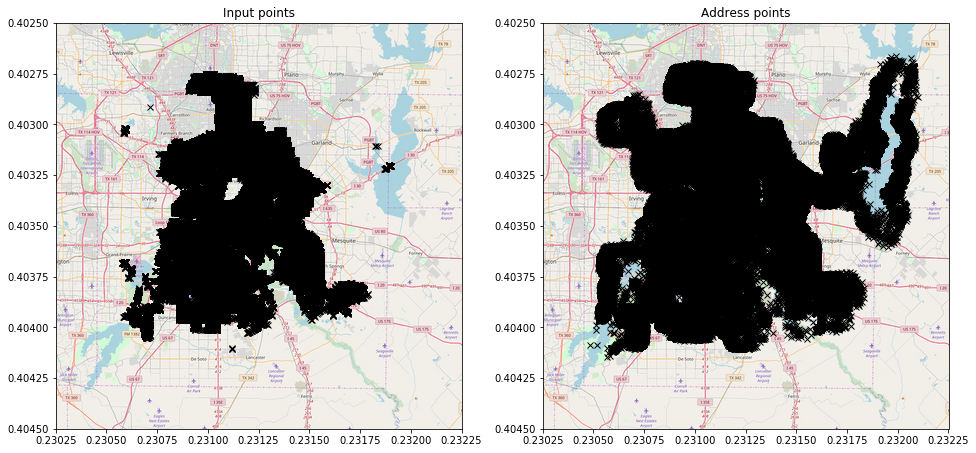

In [8]:
fig, axes = plt.subplots(ncols=2, figsize=(16,8))
ex = tilemapbase.Extent.from_centre(0.23125, 0.4035, xsize=0.002)
plotter = tilemapbase.Plotter(ex, tilemapbase.tiles.OSM, width=600)
for ax in axes:
    plotter.plot(ax)
axes[0].scatter(*pts.T, marker="x", color="black", linewidth=1)
axes[0].set_title("Input points")
axes[1].scatter(*add_pts.T, marker="x", color="black", linewidth=1)
axes[1].set_title("Address points")

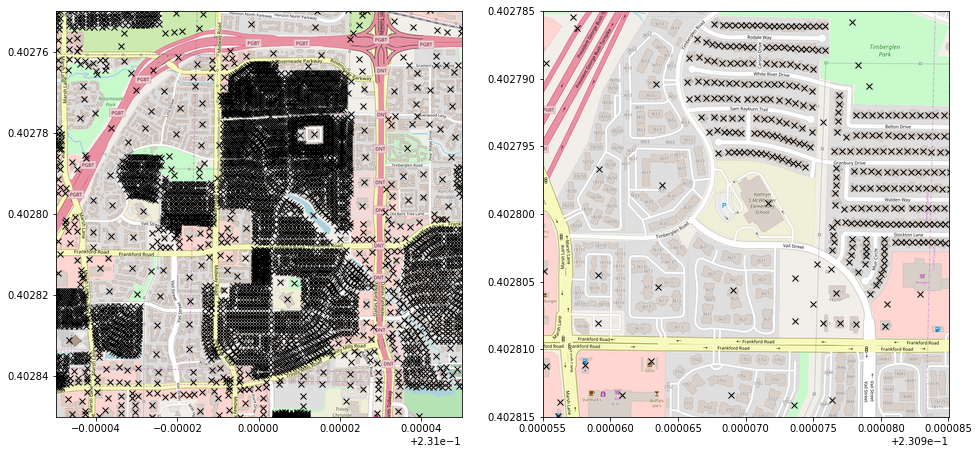

In [9]:
fig, axes = plt.subplots(ncols=2, figsize=(16,8))

ax = axes[0]
ex = tilemapbase.Extent.from_centre(0.231, 0.4028, xsize=0.0001)
plotter = tilemapbase.Plotter(ex, tilemapbase.tiles.OSM, width=600)
plotter.plot(ax)
ax.scatter(*add_pts.T, marker="x", color="black", linewidth=1)

ax = axes[1]
ex = tilemapbase.Extent.from_centre(0.231, 0.4028, xsize=0.00003)
ex = ex.with_translation(-1, 0)
plotter = tilemapbase.Plotter(ex, tilemapbase.tiles.OSM, width=600)
plotter.plot(ax)
ax.scatter(*add_pts.T, marker="x", color="black", linewidth=1)
None

## Redistribute

In [10]:
data[0]

Row(code='276285-2016', crime_type='BURGLARY', crime_subtype='BURGLARY-RESIDENCE', start_time=datetime.datetime(2016, 11, 16, 11, 0), end_time=datetime.datetime(2016, 11, 18, 11, 0), call_time=datetime.datetime(2016, 11, 18, 11, 42, 26), address='5850 BELT LINE RD', city='DALLAS 75254', lonlat=None, xy=(758190.6762580645, 2144023.8988102614))

In [11]:
address_match.closest(data[0].xy)

(array(['15000', 'WINNWOOD RD'], 
       dtype='<U31'), array([  758108.91569465,  2143910.79556146]))

In [14]:
address_match.all_in_disc(data[0].xy, 200)

(array([['15060', 'WINNWOOD RD'],
        ['15016', 'WINNWOOD RD'],
        ['15032', 'WINNWOOD RD'],
        ['15000', 'WINNWOOD RD'],
        ['5920', 'BELTLINE RD'],
        ['5907', 'BELT LINE RD']], 
       dtype='<U31'), array([[  758026.39816646,  2143963.15599538],
        [  758057.68196892,  2143880.21527462],
        [  758055.14599903,  2143910.55106901],
        [  758108.91569465,  2143910.79556146],
        [  758383.18289748,  2143977.23270906],
        [  758337.51347858,  2144098.02494696]]))

In [16]:
class AssignNew(opencrimedata.replace.AssignNew):
    def adjust(self, row):
        d = 30
        _, pts = address_match.all_in_disc(row.xy, d)
        while len(pts) == 0:
            d += 10
            _, pts = address_match.all_in_disc(row.xy, d)
        #address, pt = address_match.closest(row.xy)
        pt = pts[ np.random.choice(len(pts)) ]
        return opencrimedata.dallas.row_with_new_position(row, *pt)
    
assign = AssignNew(data, seed=1234)
with lzma.open(os.path.join(datadir, "Dallas_Redist_2.csv.xz"), "wt", newline="") as f:
    opencrimedata.dallas.write(f, assign)

# Plots

In [17]:
with lzma.open(os.path.join(datadir, "Dallas_Redist_2.csv.xz"), "rt") as f:
    data_new = {row.code : row for row in opencrimedata.dallas.load(f)}

In [18]:
with lzma.open(os.path.join(datadir, "Dallas_7_Dec_2017.csv.xz"), "rt") as f:
    data_old = {row.code : row for row in opencrimedata.dallas.load_full(f)}

## Old with lonlat to new

In [19]:
keys = set(row.code for row in data_old.values() if row.lonlat is not None)
keys.intersection_update(data_new)
keys = list(keys)
len(keys)

120223

In [20]:
old_pts = [tilemapbase.project(*data_old[key].lonlat) for key in keys]
new_pts = [tilemapbase.project(*proj(*data_new[key].xy, inverse=True)) for key in keys]

In [21]:
old_pts = np.asarray(old_pts)
new_pts = np.asarray(new_pts)

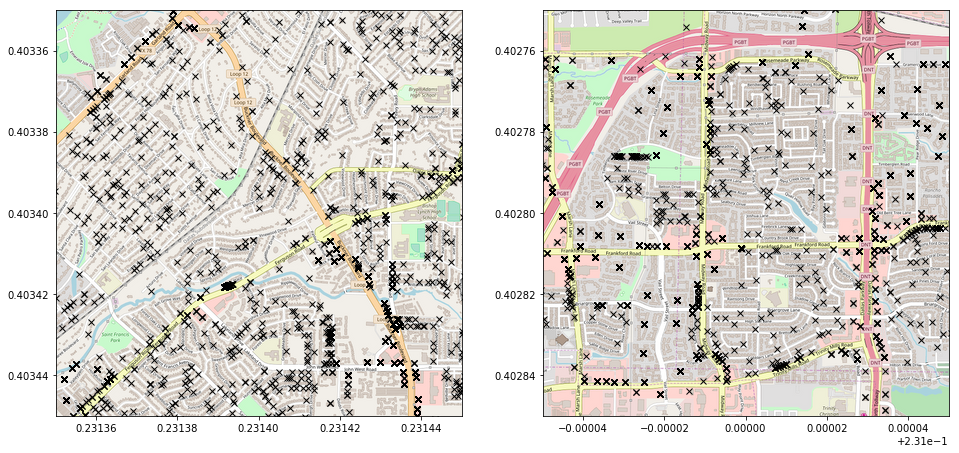

In [22]:
fig, axes = plt.subplots(ncols=2, figsize=(16,8))

ex = tilemapbase.Extent.from_centre(0.2314, 0.4034, xsize=0.0001)
plotter = tilemapbase.Plotter(ex, tilemapbase.tiles.OSM, width=600)
plotter.plot(axes[0])

ex = tilemapbase.Extent.from_centre(0.231, 0.4028, xsize=0.0001)
plotter = tilemapbase.Plotter(ex, tilemapbase.tiles.OSM, width=600)
plotter.plot(axes[1])

for ax in axes:
    ax.scatter(*new_pts.T, marker="x", color="black", linewidth=1)

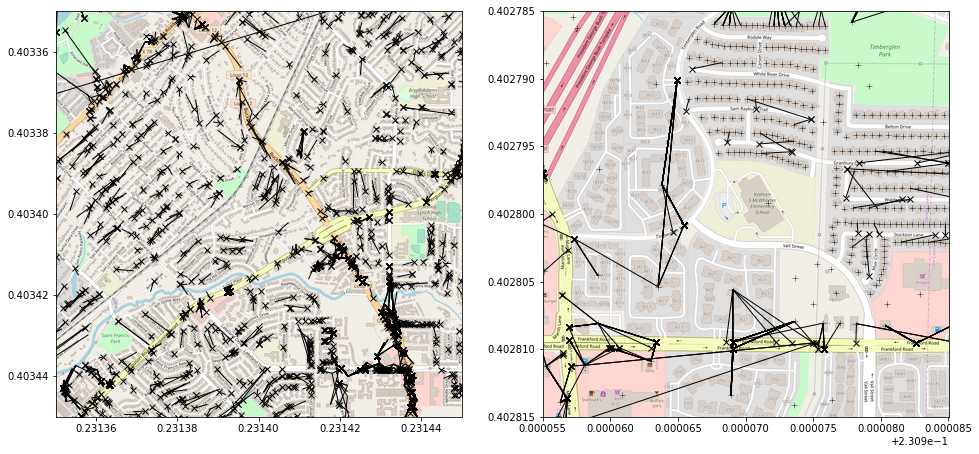

In [23]:
fig, axes = plt.subplots(ncols=2, figsize=(16,8))

ex = tilemapbase.Extent.from_centre(0.2314, 0.4034, xsize=0.0001)
plotter = tilemapbase.Plotter(ex, tilemapbase.tiles.OSM, width=600)
plotter.plot(axes[0])

ex = tilemapbase.Extent.from_centre(0.231, 0.4028, xsize=0.00003)
ex = ex.with_translation(-1, 0)
plotter = tilemapbase.Plotter(ex, tilemapbase.tiles.OSM, width=600)
plotter.plot(axes[1])
axes[1].scatter(*add_pts.T, marker="+", color="black", linewidth=0.5, alpha=0.8)

lines = list(zip(old_pts, new_pts))
for ax in axes:
    ax.add_collection(matplotlib.collections.LineCollection(lines, color="black", linewidth=1))
    ax.scatter(*old_pts.T, marker="x", color="black", linewidth=1)

In [24]:
fig.savefig("dallas_redist_to_buildings.png", dpi=150)

## Same to shapefile

In [25]:
list(data_new)[0]

'276285-2016'

In [26]:
data_new['276285-2016']

Row(code='276285-2016', crime_type='BURGLARY', crime_subtype='BURGLARY-RESIDENCE', start_time=datetime.datetime(2016, 11, 16, 11, 0), end_time=datetime.datetime(2016, 11, 18, 11, 0), call_time=datetime.datetime(2016, 11, 18, 11, 42, 26), address='5850 BELT LINE RD', city='DALLAS 75254', lonlat=None, xy=(758108.9156951993, 2143910.795561087))

In [27]:
data_old['276285-2016']

Row(code='276285-2016', crime_type='BURGLARY', crime_subtype='BURGLARY-RESIDENCE', start_time=datetime.datetime(2016, 11, 16, 11, 0), end_time=datetime.datetime(2016, 11, 18, 11, 0), call_time=datetime.datetime(2016, 11, 18, 11, 42, 26), address='5850 BELT LINE RD', city='DALLAS 75254', lonlat=(-96.807131, 32.953948), xy=(758206.7262484236, 2144003.9338816064))

In [28]:
import open_cp.geometry
open_cp.geometry.configure_gdal()
import geopandas as gpd
import shapely.geometry

In [29]:
keys[:3]

['193228-2016', '079485-2016', '245168-2016']

In [30]:
frame = gpd.GeoDataFrame({
    "code" : keys,
    "address" : [data_old[k].address for k in keys]
       })
frame.geometry = [shapely.geometry.LineString([data_new[k].xy, proj(*data_old[k].lonlat)]) for k in keys]
frame.crs = {"init":"EPSG:2845"}
frame.head()

,address,code,geometry
0,6467 MELODY LN,193228-2016,LINESTRING (763680.5152379985 2134073.52650444...
1,3625 FOLKLORE TRL,079485-2016,LINESTRING (755409.2947147574 2115717.41778714...
2,7740 MCCALLUM BLVD,245168-2016,LINESTRING (761378.181549403 2147902.630098044...
3,2817 MAPLE AVE,228679-2015,LINESTRING (758655.6416875793 2126639.65493523...
4,9845 STARLIGHT RD,073295-2016,LINESTRING (752080.2402976885 2133257.83982423...


In [31]:
frame.to_file("dallas_redist_buildings")